## Imports


In [39]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools
from sklearn.utils import shuffle


## Load Numpy Array

In [91]:
with open('numpy arrays/X.npy', 'rb') as f:
    X = np.load(f, allow_pickle=True)
    print('X loaded')
with open('numpy arrays/y.npy', 'rb') as f:
    y = np.load(f, allow_pickle=True)
    print('y loaded')

X loaded
y loaded


### Resize array

In [92]:
X, y = shuffle(X, y, random_state=0)  

In [93]:
y[100:200]

array([3, 0, 4, 3, 0, 2, 2, 3, 2, 4, 1, 3, 2, 1, 4, 0, 2, 2, 1, 4, 3, 4,
       2, 0, 3, 3, 0, 2, 4, 4, 3, 4, 3, 3, 2, 2, 2, 4, 3, 4, 4, 3, 1, 0,
       2, 0, 0, 1, 1, 3, 3, 4, 2, 0, 1, 4, 2, 3, 4, 2, 2, 3, 0, 2, 0, 3,
       3, 4, 0, 3, 3, 2, 4, 1, 3, 0, 4, 1, 3, 0, 3, 2, 2, 2, 3, 0, 0, 4,
       2, 4, 2, 4, 2, 1, 1, 1, 4, 0, 2, 4])

In [94]:
X = np.stack((X,)*3, axis=-1)
print(X.shape)

(17615, 100, 100, 3)


In [95]:
new_X = tf.image.resize(
    X, [100,100], method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None
)
new_X.shape
X = np.array(new_X)

### Train

In [96]:
from tensorflow.keras.applications import VGG16,VGG19,NASNetMobile,DenseNet201
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam

In [97]:
# Using early stopping and reduce lr on plateau to control the performance
cb_1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=0) 
cb_2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=1, mode='auto')

cbs = [cb_1 , cb_2 ]

In [98]:
from sklearn.model_selection import train_test_split
# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state = 42, stratify=y)

In [99]:
model = Sequential()

conv_base = DenseNet201(input_shape=(100,100,3), include_top=False, pooling='max',weights='imagenet')
# conv_base.trainable = False
model.add(conv_base)
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

train_layers = [layer for layer in conv_base.layers[::-1][:2]]
# print(train_layers)
# print(len(train_layers), "train len")

for layer in conv_base.layers:
  if layer in train_layers:
    layer.trainable = True

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

In [81]:
model.summary() 

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
batch_normalization_24 (Batc (None, 1920)              7680      
_________________________________________________________________
dense_24 (Dense)             (None, 2048)              3934208   
_________________________________________________________________
batch_normalization_25 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 10245     
Total params: 22,282,309
Trainable params: 3,952,389
Non-trainable params: 18,329,920
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=8, callbacks=cbs,verbose=1)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


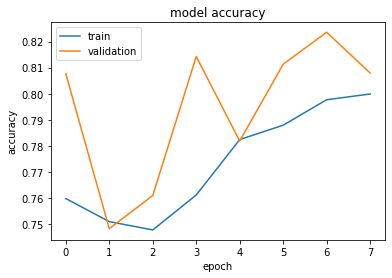

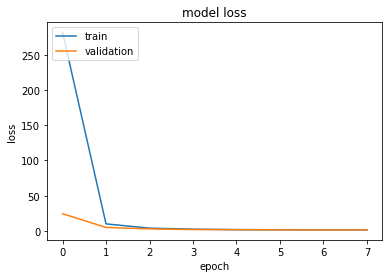

In [86]:
plot_model_results(history)

In [87]:
predictions = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, predictions)

Confusion matrix, without normalization
[[819  25  16  40   4]
 [  8 594 207   8  58]
 [  6 205 579   6  79]
 [121   1  12 736   5]
 [  8  11  23   3 830]]


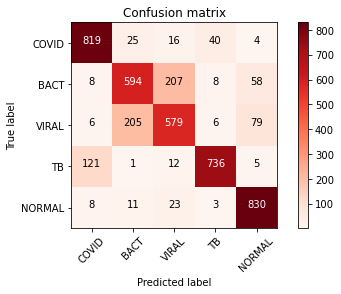

In [88]:
plot_confusion_matrix(cm, ["COVID" ,"BACT", "VIRAL", "TB", "NORMAL"])


In [89]:
print(classification_report(y_test, predictions));

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       904
           1       0.71      0.68      0.69       875
           2       0.69      0.66      0.68       875
           3       0.93      0.84      0.88       875
           4       0.85      0.95      0.90       875

    accuracy                           0.81      4404
   macro avg       0.81      0.81      0.81      4404
weighted avg       0.81      0.81      0.81      4404



### Util functions

In [84]:
def plot_model_results(history):
  print(history.history.keys())
#  "Accuracy"
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # "Loss"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [85]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes
                          ,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()